
<center><h1>Intelligence Artificielle Avancée</h1></center>
<center><h2>TP5</h2></center>

# Importation des librairies

In [ ]:
!pip install bayesian-optimization

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from bayes_opt import BayesianOptimization

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, LSTM
from keras.optimizers import Adam
from keras.api._v2.keras.callbacks import ModelCheckpoint, EarlyStopping

tf.random.set_seed(42)

# Configaration GPU

In [2]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
  print("Found GPU at:{}".format(device_name))
else:
  device_name="/device:CPU:0"
  print("No GPU")

Found GPU at:/device:GPU:0


# Importation du dataset

In [94]:
df = pd.read_excel('AirQualityUCI.xlsx')

df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
9353,2005-04-04,11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
9354,2005-04-04,12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
9355,2005-04-04,13:00:00,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


# Prétraitement du dataset

## Normalisation des données

In [95]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[df.columns[2:]] = scaler.fit_transform(df[df.columns[2:]])

df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,0.956111,0.696506,0.251980,0.803369,0.515949,0.217987,0.435782,0.579952,0.635966,0.538977,0.873262,0.861979,0.992715
1,2004-03-10,19:00:00,0.953280,0.666257,0.224622,0.793949,0.478355,0.180465,0.476541,0.541041,0.591176,0.430539,0.872036,0.857910,0.992555
2,2004-03-10,20:00:00,0.954224,0.715258,0.207343,0.792434,0.471935,0.197141,0.464834,0.581805,0.589748,0.467909,0.866312,0.879643,0.992678
3,2004-03-10,21:00:00,0.954224,0.703427,0.201584,0.793310,0.475663,0.221560,0.448183,0.596628,0.599580,0.515380,0.862633,0.900511,0.992858
4,2004-03-10,22:00:00,0.951392,0.657328,0.180706,0.783033,0.428956,0.197141,0.487382,0.585510,0.568067,0.481131,0.863246,0.899039,0.992868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,0.958471,0.676080,0.000000,0.809617,0.539043,0.400060,0.256179,0.722253,0.529160,0.708291,0.906991,0.794008,0.992710
9353,2005-04-04,11:00:00,0.955168,0.608327,0.000000,0.801372,0.508285,0.329541,0.278814,0.702613,0.491933,0.539528,0.917110,0.774872,0.992488
9354,2005-04-04,12:00:00,0.955168,0.599174,0.000000,0.805238,0.522991,0.293627,0.278640,0.694275,0.484286,0.474520,0.927637,0.756256,0.992136
9355,2005-04-04,13:00:00,0.953752,0.536890,0.000000,0.794517,0.480737,0.258785,0.312722,0.659070,0.417143,0.356166,0.933463,0.739631,0.991509


## Supression des valeurs aberrantes

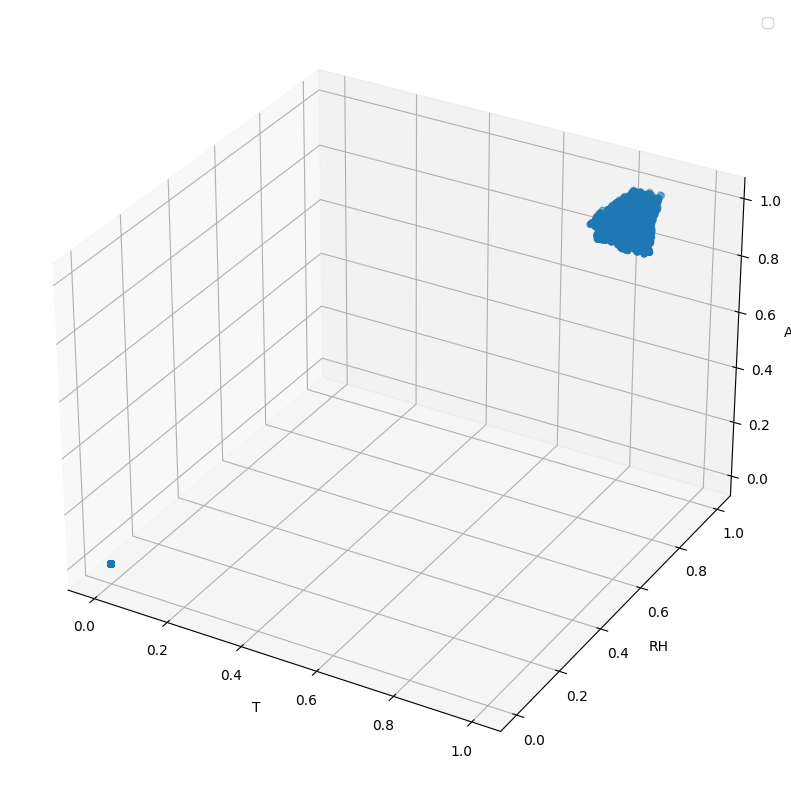

In [96]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['T'],df['RH'], df['AH'])

ax.set_xlabel('T')
ax.set_ylabel('RH')
ax.set_zlabel('AH')
ax.legend()
plt.show()

In [99]:
df.drop(df[df["AH"] < 0.6].index, inplace = True)

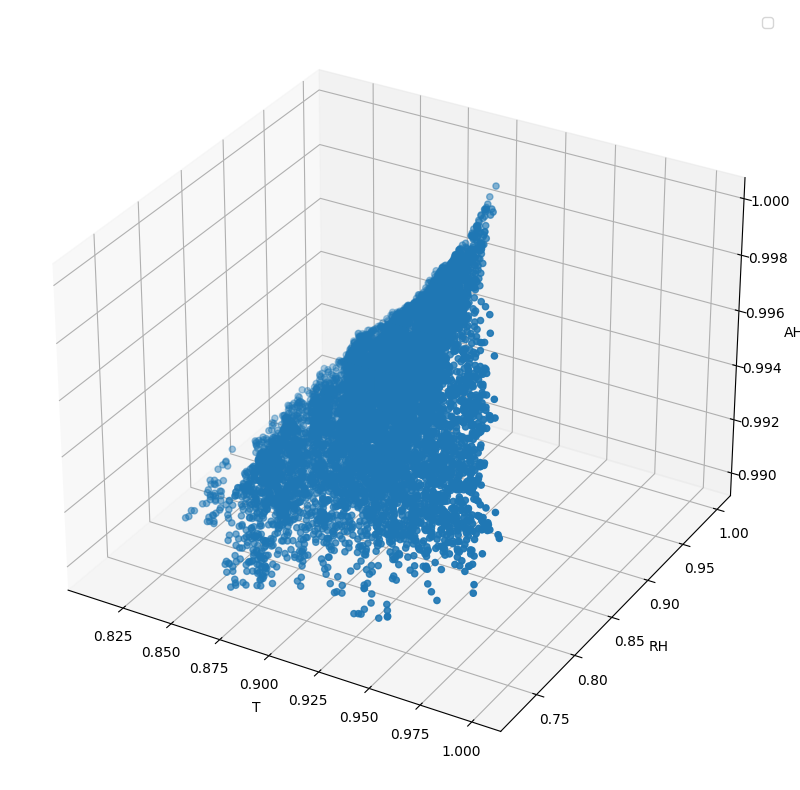

In [100]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['T'],df['RH'], df['AH'])

ax.set_xlabel('T')
ax.set_ylabel('RH')
ax.set_zlabel('AH')
ax.legend()
plt.show()

## Application du sliding window

In [37]:
def sliding_window(df, window_size):
    X = []
    y = []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:(i + window_size), 2:12].values)
        y.append(df.iloc[i + window_size, 12:15].values)
    return np.array(X), np.array(y)

In [54]:
X, y = sliding_window(df, 5)

In [58]:
X = X.astype("float32")
y = y.astype("float32")

In [55]:
X.shape, y.shape

((8986, 5, 10), (8986, 3))

## Division en set d'entrainement de validation et de teste

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=True)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=True)

In [60]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((6020, 5, 10), (6020, 3), (1483, 5, 10), (1483, 3), (1483, 5, 10), (1483, 3))

# Création de l'architecture de notre modèle

In [77]:
batch_size = 128
output_dim = 3

def LSTM_training(nbn, bs, dp):
  with tf.device(device_name):
    model = Sequential()

    model.add(LSTM(int(nbn), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dp))

    model.add(LSTM((int(nbn)*2), return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dp))

    model.add(Dense(3))
    model.add(Activation('linear'))

    checkpointer = ModelCheckpoint(filepath='air-quality-LSTM.h5', monitor='mean_squared_error', verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq=1)
    early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')

    model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_percentage_error'])

    history = model.fit(X_train, Y_train,
                          batch_size=int(bs), epochs=500,
                          verbose=0,
                          callbacks = [checkpointer, early],
                          validation_data=(X_val, Y_val))

    return -history.history['val_mean_squared_error'][-1]


# Affinage des hyperparamètres

## Utilisation de l'algorithme d'optimisatuon baysien

In [78]:
pbounds = {
    'nbn': (32, 256),
    'bs': (32, 512),
    'dp': (0.1, 0.5)
    }


optimizer = BayesianOptimization(
    f=LSTM_training,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    bs     |    dp     |    nbn    |
-------------------------------------------------------------
| 1         | -0.009437 | 232.2     | 0.3881    | 32.03     |
| 2         | -0.01641  | 177.1     | 0.1587    | 52.68     |
| 3         | -0.008625 | 121.4     | 0.2382    | 120.9     |
| 4         | -0.01088  | 290.6     | 0.2677    | 185.5     |
| 5         | -0.01101  | 130.1     | 0.4512    | 38.13     |
| 6         | -0.01457  | 353.8     | 0.2669    | 157.1     |
| 7         | -0.009127 | 99.39     | 0.1792    | 211.4     |
| 8         | -0.01308  | 496.8     | 0.2254    | 187.1     |
| 9         | -0.01128  | 452.7     | 0.4578    | 51.05     |
| 10        | -0.006654 | 50.75     | 0.1679    | 228.7     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 11        | -0.01141  | 50.48     | 0.4544    | 227.4     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 12        | -0.01039  | 287.5     | 0.415     | 71.18     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 13        | -0.008987 | 318.0     | 0.2044    | 199.3     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 14        | -0.01026  | 141.2     | 0.1622    | 244.2     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 15        | -0.01032  | 380.6     | 0.3914    | 75.61     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 16        | -0.01067  | 257.7     | 0.2694    | 137.7     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 17        | -0.01268  | 490.6     | 0.3656    | 137.4     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 18        | -0.01094  | 266.6     | 0.4365    | 251.3     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 19        | -0.009174 | 186.8     | 0.4054    | 224.0     |


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


| 20        | -0.01099  | 442.4     | 0.3877    | 236.3     |
Bayes optimization takes 787.40 seconds to tune
{'target': -0.006653585005551577, 'params': {'bs': 50.74629595178354, 'dp': 0.16793216782582757, 'nbn': 228.70392076818854}}


# Entrainement du modèle avec les meillieurs hyperparamètres

In [86]:
bs = 51
dp = 0.168
nbn = 229

with tf.device(device_name):
  model = Sequential()

  model.add(LSTM(nbn, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(dp))

  model.add(LSTM((nbn*2), return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(dp))

  model.add(Dense(3))
  model.add(Activation('linear'))

  checkpointer = ModelCheckpoint(filepath='air-quality-LSTM.h5', monitor='mean_squared_error', verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq=1)
  early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')

  model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_percentage_error'])

  history = model.fit(X_train, Y_train,
                        batch_size=bs, epochs=500,
                        verbose=2,
                        callbacks = [checkpointer, early],
                        validation_data=(X_val, Y_val))

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


119/119 - 27s - loss: 0.0332 - mean_squared_error: 0.0332 - mean_absolute_percentage_error: 33137.0859 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_percentage_error: 23821.1270 - 27s/epoch - 226ms/step
Epoch 2/500
119/119 - 10s - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_percentage_error: 19768.9492 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_percentage_error: 33708.9492 - 10s/epoch - 83ms/step
Epoch 3/500
119/119 - 2s - loss: 0.0208 - mean_squared_error: 0.0208 - mean_absolute_percentage_error: 1082.1862 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_percentage_error: 28482.6113 - 2s/epoch - 13ms/step
Epoch 4/500
119/119 - 9s - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_percentage_error: 17918.6191 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_percentage_error: 26840.3730 - 9s/epoch - 77ms/step
Epoch 5/500
119/119 - 3s - loss: 0.0181 - mean_squared_e

# Visualisation des résultats

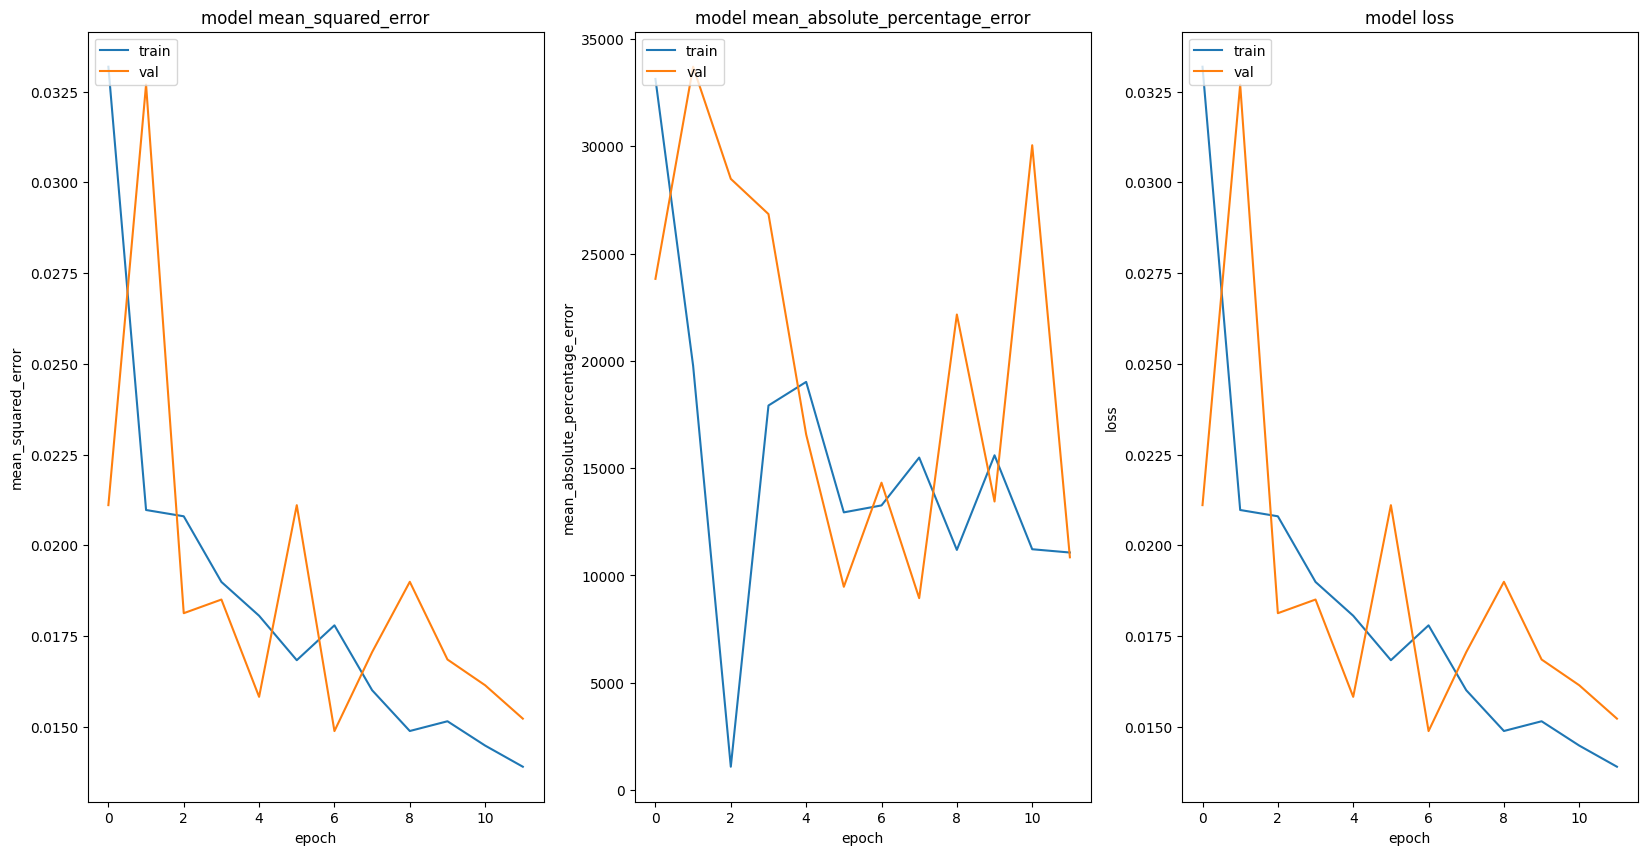

In [87]:
fig, axes = plt.subplots(1, 3,figsize=(20, 10))

axes[0].plot(history.history['mean_squared_error'])
axes[0].plot(history.history['val_mean_squared_error'])
axes[0].set_title('model mean_squared_error')
axes[0].set_ylabel('mean_squared_error')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')

axes[1].plot(history.history['mean_absolute_percentage_error'])
axes[1].plot(history.history['val_mean_absolute_percentage_error'])
axes[1].set_title('model mean_absolute_percentage_error')
axes[1].set_ylabel('mean_absolute_percentage_error')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'val'], loc='upper left')

axes[2].plot(history.history['loss'])
axes[2].plot(history.history['val_loss'])
axes[2].set_title('model loss')
axes[2].set_ylabel('loss')
axes[2].set_xlabel('epoch')
axes[2].legend(['train', 'val'], loc='upper left')

# Test du modèle

In [88]:
y_pred = model.predict(X_test)

47/47 [==============================] - 1s 3ms/step


## Remettre les données a leur échelle d'origine pour une meillieur visualisation

In [89]:
y_pred_extended = np.append(X_test[:, 0, :], y_pred, 1)
y_test_extended = np.append(X_test[:, 0, :], Y_test, 1)
y_pred_extended.shape, y_test_extended.shape

((1483, 13), (1483, 13))

In [90]:
testPredict = scaler.inverse_transform(y_pred_extended)[:, 10:]
Y_test_d = scaler.inverse_transform(y_test_extended)[:, 10:]

## Visualisation des résultats du test

In [91]:
testScore = np.sqrt(mean_squared_error(Y_test_d, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 8.18 RMSE


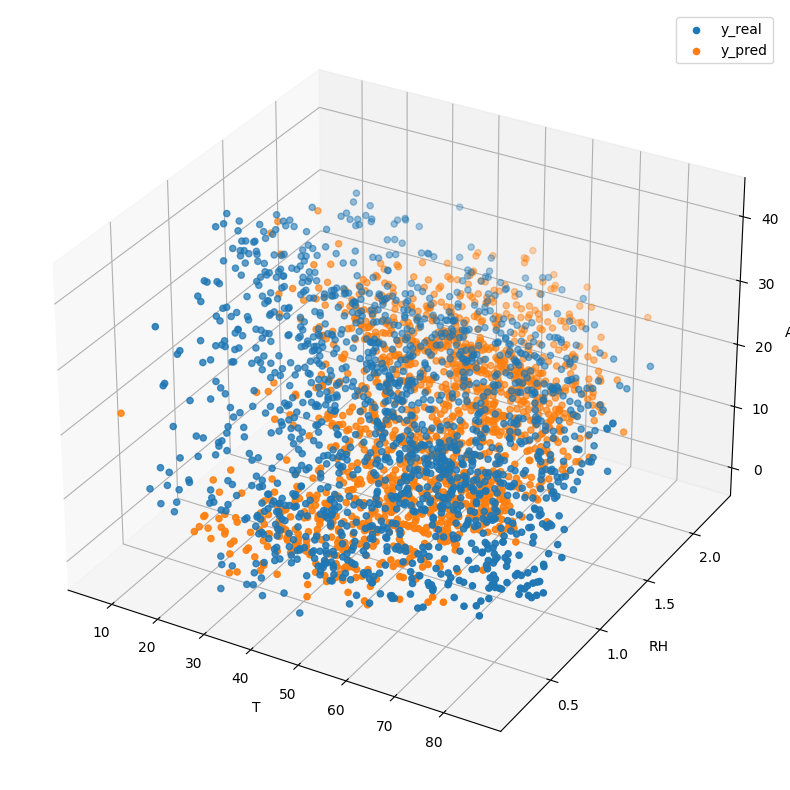

In [92]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y_test_d[:, 1], Y_test_d[:, 2], Y_test_d[:, 0], label='y_real')
ax.scatter(testPredict[:, 1], testPredict[:, 2], testPredict[:, 0], label='y_pred')
ax.set_xlabel('T')
ax.set_ylabel('RH')
ax.set_zlabel('Ah')
ax.legend()
plt.show()